In [1]:
import matplotlib.pyplot as plt
import numpy as np
from random import random

from society.agent import Agent, TrainableAgent
from society.simulations.weighted import WeightedNetworkSimulation
from society.strategies.gameplay.constant import AllC, AllD
from society.strategies.gameplay.random import RandomGameplayStrategy
from society.strategies.gameplay.tft import TitForTat
from society.strategies.gameplay.qlearning import TabularQLearningGameplayStrategy
from society.visualisation.network import *
from society.action import Action

plt.rcParams["figure.figsize"] = (10, 6)

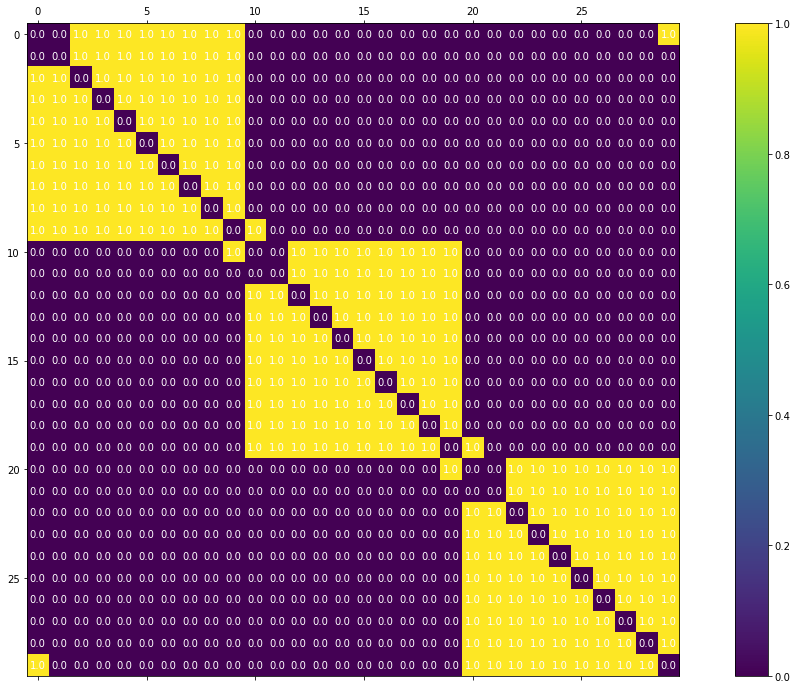

In [2]:
POPULATION = 30
agents = [
    Agent(None, TabularQLearningGameplayStrategy(lookback=2), i, POPULATION)
    for i in range(POPULATION)
]

# for i in range(1, 9):
#     agents[i] = Agent(None, TitForTat(), i, POPULATION)

G = nx.connected_caveman_graph(3, 10)

weights_matrix = np.zeros((POPULATION, POPULATION))
for u, v, d in G.edges(data=True):
    weights_matrix[u, v] = weights_matrix[v, u] = 1.0
    try:
        d["weight"] = weights_matrix[u, v]
    except:
        d["weight"] = 0

plot_matrix(weights_matrix, digits=2, figsize=(20, 12))

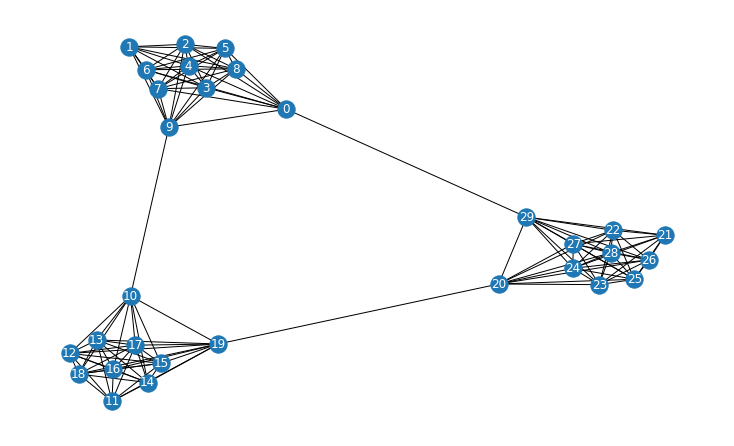

In [3]:
nx.draw(G, pos=nx.spring_layout(G), font_color="white", with_labels=True)

In [4]:
sim = WeightedNetworkSimulation(agents, weights_matrix)
sim.reset()

for i in range(100000):
    sim.play_round()


[(19, 525346), (9, 524324), (29, 521136), (28, 514645), (8, 510065), (25, 508139), (14, 502031), (27, 501470), (15, 501077), (21, 497916), (2, 497217), (20, 496844), (16, 492224), (22, 491368), (26, 489761), (5, 489756), (18, 488214), (7, 488100), (24, 487966), (13, 487627), (23, 486905), (3, 485072), (12, 484499), (17, 481046), (10, 479386), (6, 477364), (4, 475826), (11, 473781), (0, 467413), (1, 448559)]


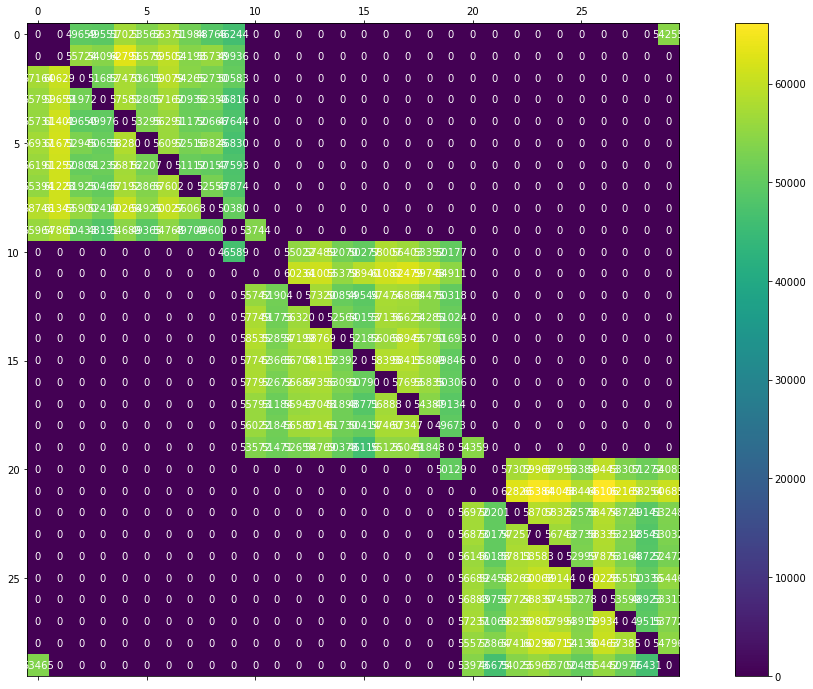

In [5]:
returns_matrix = [[sum(r) if len(r) > 0 else 0 for r in agent] for agent in sim.rewards]
ranked_partners = sorted([(i, sum(returns_matrix[i])) for i in range(POPULATION)], key=lambda x: x[1], reverse=True)
print(ranked_partners)

plot_matrix(returns_matrix, figsize=(20, 12))

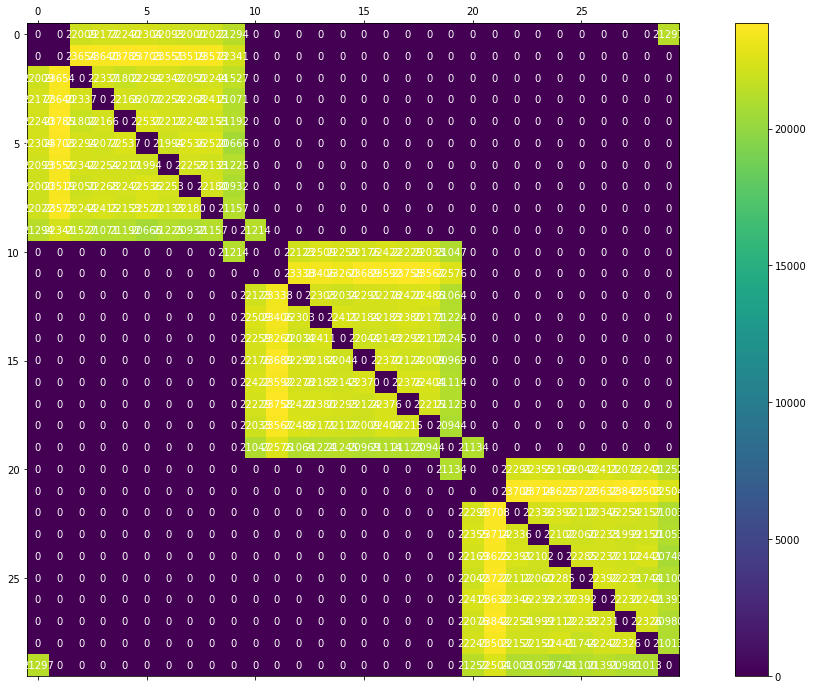

In [6]:
frequency_matrix = [[len(r) for r in agent] for agent in sim.rewards]

plot_matrix(frequency_matrix, figsize=(20, 12))

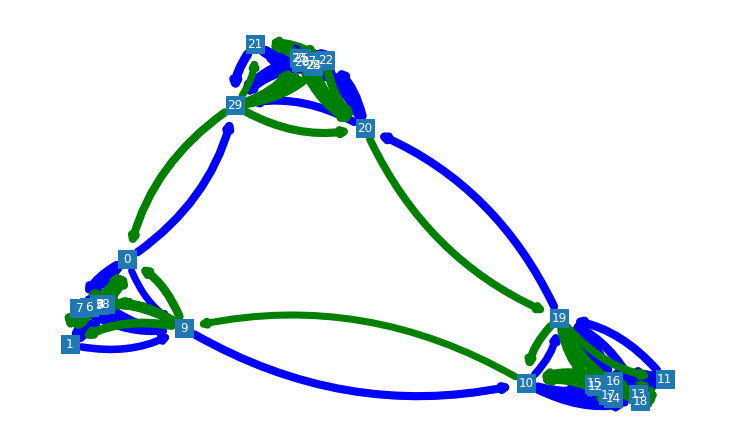

In [7]:
dg = nx.MultiDiGraph(G)

for u, v, d in dg.edges(data=True):
    try:
        d["weight"] = returns_matrix[u][v]
    except:
        d["weight"] = 0

plot_graph_spring(dg)

In [8]:
nx.drawing.nx_pydot.write_dot(dg, "test7.dot")

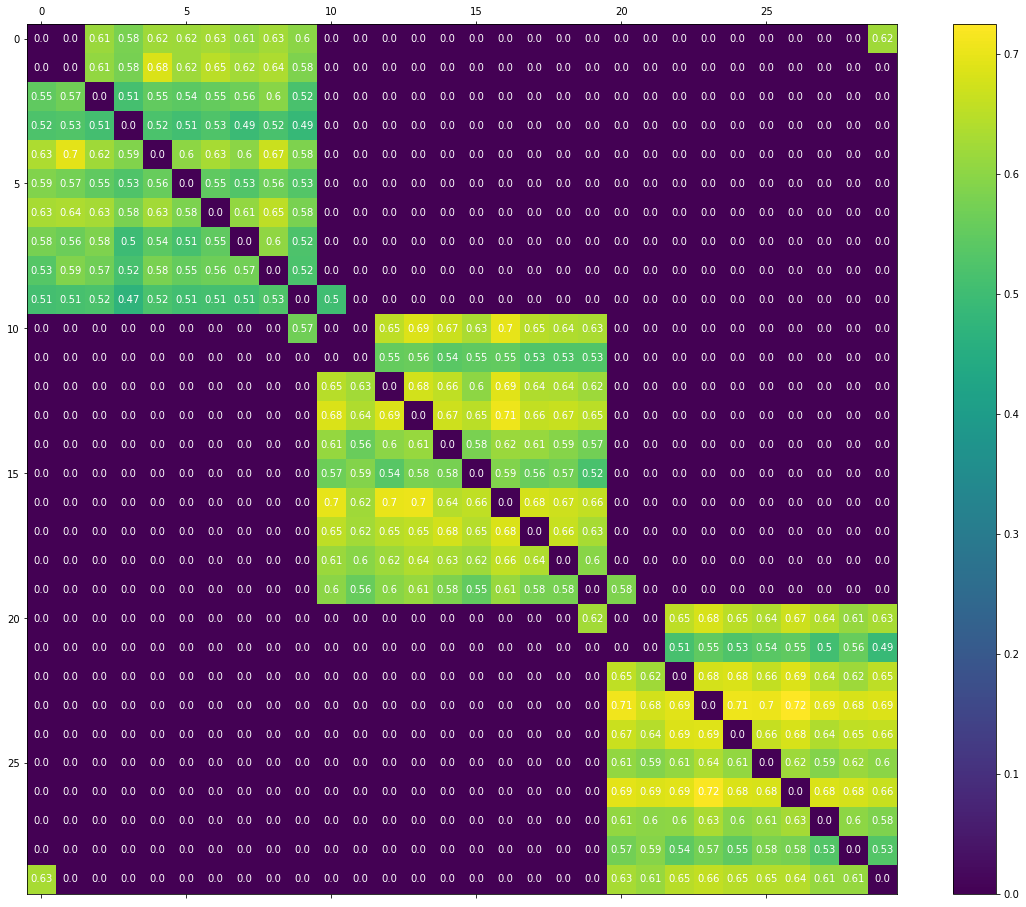

In [9]:
cooperativeness_matrix = [[r.count(Action.COOPERATE) / len(r) if r else 0 for r in agent] for agent in sim.histories]

plot_matrix(cooperativeness_matrix, figsize=(20, 16), digits=2)

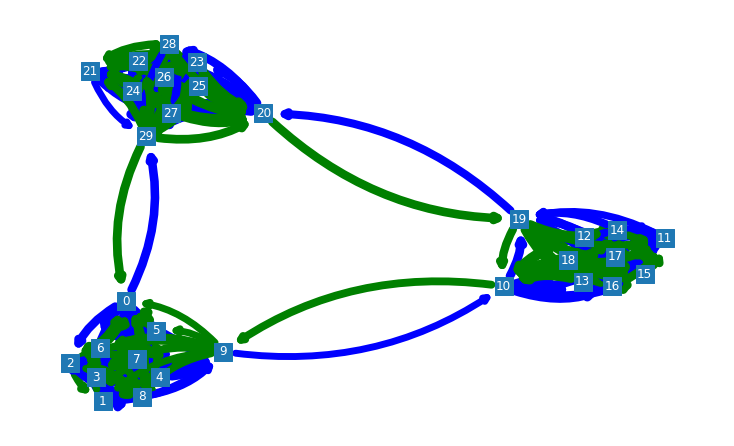

In [10]:
cooperativeness_graph = nx.MultiDiGraph(G)

for u, v, d in cooperativeness_graph.edges(data=True):
    try:
        d["weight"] = sim.histories[u][v].count(Action.COOPERATE) / len(sim.histories[u][v])
    except:
        d["weight"] = 0

plot_graph_spring(cooperativeness_graph)

nx.drawing.nx_pydot.write_dot(dg, "test7-coop.dot")

In [15]:
policy = np.zeros((4, 4))

for agent in agents:
    policy += agent.gameplay_strategy._q_table.argmax(axis=-1)

policy /= len(agents)

policy

array([[0.46666667, 0.73333333, 0.26666667, 0.63333333],
       [0.5       , 0.93333333, 0.36666667, 0.7       ],
       [0.53333333, 0.66666667, 0.16666667, 0.7       ],
       [0.33333333, 0.63333333, 0.36666667, 0.36666667]])

In [24]:
actions = ["(C, C)", "(C, D)", "(D, C)", "(D, D)"]

for i, a in enumerate(actions):
    for j, b in enumerate(actions):
        print(f"{a:<8} {b:<8} => {('C', 'D')[round(policy[i, j])]:<4} [{round(policy[i, j], 5):05f}]")

(C, C)   (C, C)   => C    [0.466670]
(C, C)   (C, D)   => D    [0.733330]
(C, C)   (D, C)   => C    [0.266670]
(C, C)   (D, D)   => D    [0.633330]
(C, D)   (C, C)   => C    [0.500000]
(C, D)   (C, D)   => D    [0.933330]
(C, D)   (D, C)   => C    [0.366670]
(C, D)   (D, D)   => D    [0.700000]
(D, C)   (C, C)   => D    [0.533330]
(D, C)   (C, D)   => D    [0.666670]
(D, C)   (D, C)   => C    [0.166670]
(D, C)   (D, D)   => D    [0.700000]
(D, D)   (C, C)   => C    [0.333330]
(D, D)   (C, D)   => D    [0.633330]
(D, D)   (D, C)   => C    [0.366670]
(D, D)   (D, D)   => C    [0.366670]


In [28]:
best_agent = agents[ranked_partners[0][0]]

best_policy = best_agent.gameplay_strategy._q_table.argmax(axis=-1)

for i, a in enumerate(actions):
    for j, b in enumerate(actions):
        print(f"{a:<8} {b:<8} => {('C', 'D')[round(best_policy[i, j])]:<4}")


(C, C)   (C, C)   => C   
(C, C)   (C, D)   => D   
(C, C)   (D, C)   => C   
(C, C)   (D, D)   => C   
(C, D)   (C, C)   => C   
(C, D)   (C, D)   => D   
(C, D)   (D, C)   => C   
(C, D)   (D, D)   => D   
(D, C)   (C, C)   => C   
(D, C)   (C, D)   => D   
(D, C)   (D, C)   => C   
(D, C)   (D, D)   => D   
(D, D)   (C, C)   => C   
(D, D)   (C, D)   => D   
(D, D)   (D, C)   => C   
(D, D)   (D, D)   => C   


In [31]:
best_agent.gameplay_strategy._q_table

array([[[263.15429284, 262.00709482],
        [258.97552432, 260.00452752],
        [259.27928797, 252.89492101],
        [258.63060735, 245.9164065 ]],

       [[260.91436979, 252.70027889],
        [234.9773135 , 257.43651404],
        [258.55544163, 256.98402693],
        [248.45845891, 258.75868952]],

       [[259.56530078, 256.93341268],
        [259.92328478, 260.63946135],
        [255.92153819, 238.50392189],
        [249.65089726, 258.40409433]],

       [[260.29482289, 251.6950207 ],
        [248.98555476, 260.12982833],
        [259.51099395, 240.96543539],
        [259.69408587, 256.30286551]]])

In [30]:
worst_agent = agents[ranked_partners[-1][0]]

worst_policy = worst_agent.gameplay_strategy._q_table.argmax(axis=-1)

for i, a in enumerate(actions):
    for j, b in enumerate(actions):
        print(f"{a:<8} {b:<8} => {('C', 'D')[round(worst_policy[i, j])]:<4}")


(C, C)   (C, C)   => D   
(C, C)   (C, D)   => D   
(C, C)   (D, C)   => C   
(C, C)   (D, D)   => D   
(C, D)   (C, C)   => D   
(C, D)   (C, D)   => D   
(C, D)   (D, C)   => C   
(C, D)   (D, D)   => D   
(D, C)   (C, C)   => C   
(D, C)   (C, D)   => C   
(D, C)   (D, C)   => C   
(D, C)   (D, D)   => C   
(D, D)   (C, C)   => C   
(D, D)   (C, D)   => D   
(D, D)   (D, C)   => C   
(D, D)   (D, D)   => C   
